# Give me Attention! ... in Image Classification (with MNIST)

Contributor: michaelmenzel@google.com

Various experiments which explore attention mechanisms and their influence on prediction accuracy and complexity. This notebook focuses on experiments with Vision Transformer (ViT).

In [1]:
#@title Imports
!pip install --upgrade -q matplotlib
import numpy as np
import math

import cv2

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
if matplotlib.__version__ < '3.4.2':
  print('Need to restart runtime. Please rerun the cells.')
  import os
  os.kill(os.getpid(), 9)

import matplotlib.pyplot as plt
from matplotlib import gridspec

matplotlib: 3.5.2


In [2]:
#@title Load MNIST
(mnist_train, mnist_test), mnist_info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)

mnist_train = mnist_train.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_train_batched = mnist_train.batch(128).prefetch(tf.data.AUTOTUNE)
mnist_test = mnist_test.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_test_batched = mnist_test.batch(128).prefetch(tf.data.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
#@title Configuration

num_classes = mnist_info.features['label'].num_classes
image_size = mnist_info.features['image'].shape[0]
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 16
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
mlp_head_units = [32, 16]

Following several helper functions and classes to construct the model and plot samples.

In [4]:
#@title Helper Functions
def mlp(input, hidden_units, dropout_rate):
    for units in hidden_units:
        dense = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(input)
        dropout = tf.keras.layers.Dropout(dropout_rate)(dense)
    return dropout

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def attention_map(mha_outs):
  mha_img = tf.reshape(
    tf.transpose(tf.stack(mha_outs), perm=[1, 0, 2, 3, 4]), 
    shape=[-1, transformer_layers, num_heads, num_patches, num_patches])
  
  mha_img = (mha_img - tf.reduce_min(mha_img)) / (tf.reduce_max(mha_img) - tf.reduce_min(mha_img))
  mha_img = mha_img + tf.eye(mha_img.shape[-1])
  mha_img = tf.math.reduce_sum(mha_img, axis=-2)
  patch_dim = int(math.sqrt(num_patches))
  mha_img = tf.reshape(mha_img, shape=(-1, transformer_layers, num_heads, patch_dim, patch_dim))
  mha_img = tf.math.reduce_mean(mha_img, axis=2)
  #mha_img, _ = tf.linalg.normalize(mha_img, ord=2, axis=-2)

  v = mha_img[:,-1]
  for n in range(1, mha_img.shape[1]):
      v = tf.matmul(v, mha_img[:,-n])
  return v

def plot_test_sample(model):
  fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

  for i, sample in enumerate(mnist_test.batch(1).take(10)):
    axs[0,i].imshow(sample[0][0], cmap='inferno')
    predicted = model(sample[0])
    mask = predicted['mha'][0].numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = cv2.resize(mask, (image_size, image_size))
    axs[1,i].imshow(mask, vmin=0, vmax=1, cmap='inferno')
    top = mask > np.percentile(mask, 70)
    top_masked = np.array(sample[0][0])
    top_masked[~top] = 0
    axs[2,i].imshow(top_masked, cmap='inferno')
    print(f'actual: {sample[1][0]}, predicted: {tf.argmax(predicted["class_one_hot"][0])}')

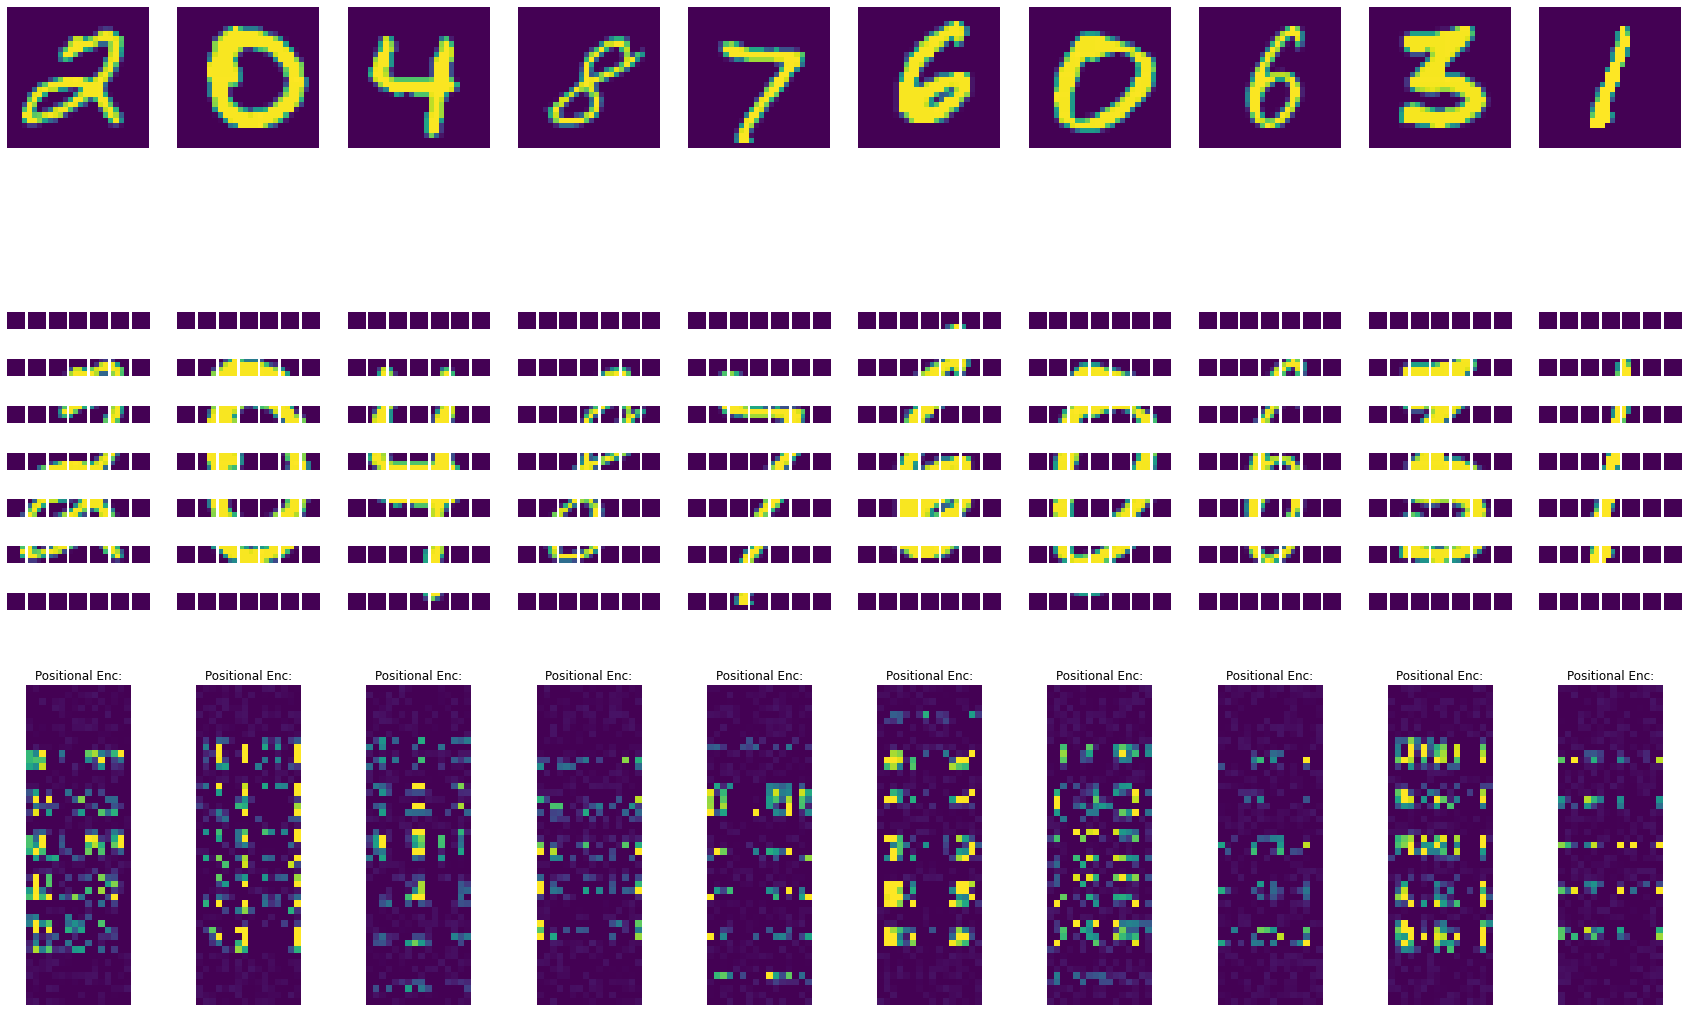

In [13]:
#@title Plot Sample
fig = plt.figure(figsize=(30, 20))
grid = fig.add_gridspec(3, 10)

for i, sample in enumerate(mnist_test.take(10)):
  ax0 = fig.add_subplot(grid[0,i])
  ax0.imshow(sample[0], vmin=0, vmax=1)
  ax0.set_axis_off()

  sample_patches = Patches(patch_size)([tf.expand_dims(sample[0], axis=-1)])
  patched_grid = grid[1,i].subgridspec(image_size // patch_size, image_size // patch_size)
  ax1 = patched_grid.subplots().flatten()
  
  for j, patch in enumerate(sample_patches[0]):
      patch_img = tf.reshape(patch, (patch_size, patch_size))
      ax1[j].imshow(patch_img, vmin=0, vmax=1)
      ax1[j].set_axis_off()

  ax2 = fig.add_subplot(grid[2,i])
  ax2.title.set_text('Positional Enc:')
  encoded_patches = PatchEncoder(num_patches, projection_dim)(sample_patches)
  ax2.imshow(tf.squeeze(encoded_patches), vmin=0, vmax=1)
  ax2.set_axis_off()

fig.show()

In [ ]:
input = tf.keras.layers.Input(shape=(image_size,image_size, 1))

patches = Patches(patch_size)(input)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

mhas = []
for i in range(transformer_layers):
  normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  mha_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=projection_dim, dropout=0.1
  )
  attention_output, attention_scores = mha_layer(normed, normed, return_attention_scores=True)
  #mhas.append(tf.stack(tf.split(attention_output, num_heads, axis=-1)))
  mhas.append(attention_scores)
  skip_merge = tf.keras.layers.Add()([attention_output, encoded_patches])
  normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip_merge)
  features = mlp(normed, hidden_units=transformer_units, dropout_rate=0.1)
  encoded_patches = skip_merge2 = tf.keras.layers.Add()([features, skip_merge])

output_mha = attention_map(mhas)

normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip_merge2)
flat = tf.keras.layers.Flatten()(normed)
dropout = tf.keras.layers.Dropout(0.5)(flat)
features = mlp(dropout, hidden_units=mlp_head_units, dropout_rate=0.5)
output = tf.keras.layers.Dense(num_classes, name='output')(features)

model = tf.keras.Model(inputs=input, outputs={'class_one_hot': output, 'mha': output_mha})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 patches_10 (Patches)           (None, None, 16)     0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 49, 16)       1056        ['patches_10[0][0]']             
                                                                                                  
 layer_normalization (LayerNorm  (None, 49, 16)      32          ['patch_encoder[0][0]']          
 alization)                                                                                   

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
model.compile(optimizer='adam', 
              loss={'class_one_hot': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'mha': lambda x,y: 0}, 
              metrics={'class_one_hot': tf.keras.metrics.SparseCategoricalAccuracy(), 'mha': None})
model.fit(mnist_train_batched, validation_data=mnist_test_batched, epochs=200)

Epoch 1/200
469/469 [==============================] - 18s 25ms/step - loss: 2.3066 - output_loss: 2.3066 - tf.linalg.matmul_1_loss: 0.0000e+00 - output_sparse_categorical_accuracy: 0.1101 - val_loss: 2.3005 - val_output_loss: 2.3005 - val_tf.linalg.matmul_1_loss: 0.0000e+00 - val_output_sparse_categorical_accuracy: 0.1135
Epoch 2/200
469/469 [==============================] - 7s 16ms/step - loss: 2.2613 - output_loss: 2.2613 - tf.linalg.matmul_1_loss: 0.0000e+00 - output_sparse_categorical_accuracy: 0.1452 - val_loss: 2.1044 - val_output_loss: 2.1044 - val_tf.linalg.matmul_1_loss: 0.0000e+00 - val_output_sparse_categorical_accuracy: 0.5133
Epoch 3/200
469/469 [==============================] - 7s 16ms/step - loss: 1.9611 - output_loss: 1.9611 - tf.linalg.matmul_1_loss: 0.0000e+00 - output_sparse_categorical_accuracy: 0.4610 - val_loss: 1.7126 - val_output_loss: 1.7126 - val_tf.linalg.matmul_1_loss: 0.0000e+00 - val_output_sparse_categorical_accuracy: 0.8044
Epoch 4/200
469/469 [======

actual: 2, predicted: 2
actual: 0, predicted: 0
actual: 4, predicted: 4
actual: 8, predicted: 8
actual: 7, predicted: 7
actual: 6, predicted: 6
actual: 0, predicted: 0
actual: 6, predicted: 6
actual: 3, predicted: 3
actual: 1, predicted: 1


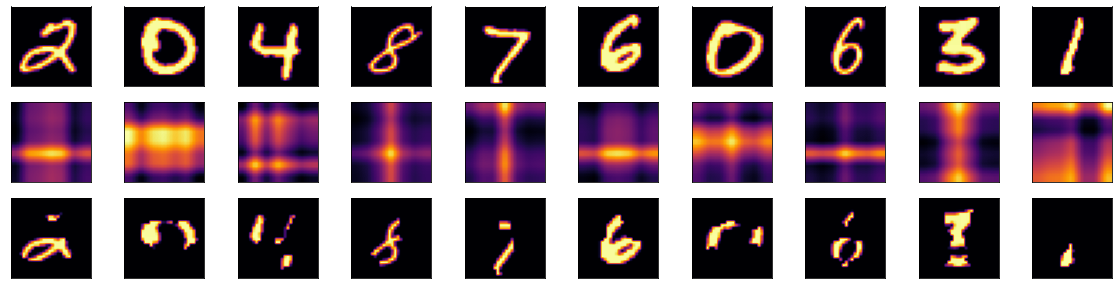

In [ ]:
plot_test_sample(model)